# PAI Task 1 Description : Group Chewbhan

# Gaussian Process Regression

According to the United Nations, one in three people worldwide do not have access to safe drinking water. Unsafe water is a leading risk factor for death, especially at low incomes, and is one of the world's largest health and environmental problems. Groundwater pollution occurs when pollutants are released into the ground and make their way down into groundwater. While water contamination can occur from naturally occurring contaminants, such as arsenic or fluoride, common causes of water pollution are on-site sanitation systems, effluent from wastewater treatment plants, petrol filling stations or agricultural fertilizers.

In order to prevent outbreaks and incidents of water poisonings, detecting ground-water contamination is crucial. Geostatistics has often utilized the Gaussian Process (GP) to model the spatial pattern of pollutant concentrations in the ground. Usually, a data point in 2D represents a geological well where a sample was taken from a bore hole to measure concentration of pollutants.

In the following task, we will use Gaussian Process regression (or a similar method) in order to model groundwater pollution, and try to predict the concentration of pollutants at previously unmeasured wells (points).

In order to perfom this task we followed the GPytorch Regression Tutorial : https://docs.gpytorch.ai/en/v1.2.0/examples/01_Exact_GPs/Simple_GP_Regression.html

## Imports

In [1]:
import numpy as np
from scipy.stats import norm
import torch
import gpytorch

## Read data

In [2]:
# load the training data
train_x_name = "train_x.csv"
train_y_name = "train_y.csv"

train_x = np.loadtxt(train_x_name, delimiter=',')
train_y = np.loadtxt(train_y_name, delimiter=',')

# load the test dateset
test_x_name = "test_x.csv"
test_x = np.loadtxt(test_x_name, delimiter=',')


## Cost function

In [3]:
## Constant for Cost function
THRESHOLD = 0.5
W1 = 1
W2 = 20
W3 = 100
W4 = 0.04


def cost_function(true, predicted):
    """
        true: true values in 1D numpy array
        predicted: predicted values in 1D numpy array
        return: float
    """
    cost = (true - predicted)**2

    # true above threshold (case 1)
    mask = true > THRESHOLD
    mask_w1 = np.logical_and(predicted>=true,mask)
    mask_w2 = np.logical_and(np.logical_and(predicted<true,predicted >=THRESHOLD),mask)
    mask_w3 = np.logical_and(predicted<THRESHOLD,mask)

    cost[mask_w1] = cost[mask_w1]*W1
    cost[mask_w2] = cost[mask_w2]*W2
    cost[mask_w3] = cost[mask_w3]*W3

    # true value below threshold (case 2)
    mask = true <= THRESHOLD
    mask_w1 = np.logical_and(predicted>true,mask)
    mask_w2 = np.logical_and(predicted<=true,mask)

    cost[mask_w1] = cost[mask_w1]*W1
    cost[mask_w2] = cost[mask_w2]*W2

    reward = W4*np.logical_and(predicted < THRESHOLD,true<THRESHOLD)
    if reward is None:
        reward = 0
    return np.mean(cost) - np.mean(reward)


## Set up the model

In order to set up the model we will need different object :
* a Gaussian Process (GP) Model
* a Likelihood
* a Mean (defining the prior mean of the GP)
* a Kernel (defining the prior covariance of the GP)
* a MultivariateNormal Distribution

### The GP Model

In order to construct the model we had to choose the Mean, the kernel and the multivariatenormal distribution. From the GPytorch package we choosed the following one :
* Mean : ConstantMean() [https://docs.gpytorch.ai/en/v1.1.1/_modules/gpytorch/means/constant_mean.html#ConstantMean]
* Kernel : RBFKernel() (squared exponential kernel)  [https://docs.gpytorch.ai/en/v1.1.1/_modules/gpytorch/kernels/]

    $\begin{equation*}
       k_{\text{RBF}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( -\frac{1}{2}
       (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-2} (\mathbf{x_1} - \mathbf{x_2}) \right)
    \end{equation*}$
    

* Distribution : MultivariateNormal(mean, covar) [https://docs.gpytorch.ai/en/v1.1.1/_modules/gpytorch/distributions/multivariate_normal.html#MultivariateNormal] . Recap: a vector X or random variable is said to have a multivariate normal distribution if its density function f(X) is of the form :

    $\begin{eqnarray}
    f({\bf X}) & = & f(X_1, \, X_2, \, \ldots, \, X_p) \\
         & = & \left( \frac{1}{2 \pi} \right)^{p / 2} |{\bf \Sigma}|^{-1/2} \mbox{exp} 
               \left[ -\frac{1}{2} ({\bf X} - {\bf m})' {\bf \Sigma}^{-1} ({\bf X} - {\bf m}) \right] \, ,
    \end{eqnarray}$


Other possibilities of mean or kernel could have been used, but these ones well fited the task. You can find the different package here : [https://docs.gpytorch.ai/en/v1.1.1/index.html]

A GPModel is composed as follow :

* An __init__ method that takes the trraining data (X, y) and a likelihood and construct what is necessecary for the *forward* function of the model. It construct the mean and the covar (kernel) Modules
* A __forward__ methos that takes as argument *n x d* [X]  data and returns a MultivariateNormal with the prior mean and covariance evaluated at X. So it concretely return mu(X) and the *n x n* covariance matrix Kxx.

In GPyTorch, an ExactGP has .train() and .eval() mode that are used respectively to optimize model hyperparameters and to compute prediction.

NB: We tried the RQKernel() (rational quadratic kernel) but result were not good enough


In [4]:
# Simplest form of Gaussian Model, Inference (cf. Tutorial)
class ExactGPModel(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Initialize Model and likelihood

As said in the project description, with Bayesian models, a commonly used principle in choosing the right kernel or hyper-parameters is to use the "data likelihood", otherwise known as the marginal likelihood to find the best model. We decided to follow this advice and to use the Gaussian Likelihood proposed by GPyTorch (and we will see later that we use the ExactMarginalLogLikelihood as losse function)

Moreover, as we use GPyTorch function we have ton use tensor instead of numpy array. This is why we 'cast' our training set into Tensor.

We already define the number of iteration use for the training loop. Be default this number is 50 (cf. tutorial), we tried different value (25, 100, 150) but 50 seemed to us being the best compromise between performance and computation time. Also with a too high number of iteration we sometimes see the loss become bigger and we suspected overfitting the data.

In [5]:
#First we need to convert our training set into tensor
train_x = torch.Tensor(train_x)
train_y = torch.Tensor(train_y)

#Then we initialize the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Number of iteration for the training loop
iteration = 50

## Large scale learning

It is stated in the project description that : 

> Natively, GP inference is computationally intensive for large datasets and common-place computers. The inference requires O(N^3) basic operations in order find the posterior distributions. For large datasets this becomes infeasible. In order to solve this problem, practitioners use forms of low-rank approximations. The most popular are the Nyström method, using random features and/or other scalable clustering-based approaches

Fortunately, with GPyTorch the computation time was quite reasonable (around 2 min), so we decided to not implement this method.


## Fit/Train the model

We are now going to fit our model, find the hyperparameters etc. As described in the tutorial :
> The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from torch.optim, and all trainable parameters of the model should be of type torch.nn.Parameter. Because GP models directly extend torch.nn.Module, calls to methods like model.parameters() or model.named_parameters() function as you might expect coming from PyTorch.

In order to well fiting our model we will have to : 
* Turn the model in training mode to find the optimal hyperparameters
* Find an adequat optimizer 
* Compute the marginal log likelihood (MLL)
* Define a training Loop

### Training mode

First we tell our model to turn the train mode. We can do it via the pytorch function __.train()__ . This function is define as follow :

    def train(self, mode=True):
        r"""Sets the module in training mode."""      
        self.training = mode
        for module in self.children():
            module.train(mode)
        return self



In [6]:
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Optimizer

Then we search a good optimizer. We tried the two following one :
* Adaptive Moment Estimation (Adam) optimizer with learning rate 0.01 ?
* SGD optimizer with learnin rate 0.01 and momentum 0.9

You can find more info on both optimizer here [https://pytorch.org/docs/stable/optim.html]

The adam optimizer can be described as follow :
* Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
* Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
* Adam is relatively easy to configure where the default configuration parameters do well on most problems.
* We compute the decaying averages of past and past squared gradients __mt__ and __vt__ respectively as follows: 
$
    \begin{align} 
    \begin{split} 
        m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\ 
        v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 
    \end{split} 
    \end{align} 
$

More info on the different optimizer that exist and how they work her : [https://ruder.io/optimizing-gradient-descent/index.html]

In PyTorch, the adam optimizer is presented as follow : torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


After testing we choosed the Adam optimizer as it worked better with our model. We also tried different learning rate value (0.001, 0.0001 etc) but 0.01 was gave us the best results

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


### Marginal Log Likelihood 

We now need to compute, or approximate/bound, the MLL.
$$
\begin{equation*}
   \mathcal{L} = p_f(\mathbf y \! \mid \! \mathbf X)
   = \int p \left( \mathbf y \! \mid \! f(\mathbf X) \right) \: p(f(\mathbf X) \! \mid \! \mathbf X) \: d f
\end{equation*}
$$

In GPyTorch there is the exact marginal log likelihood for an exact Gaussian process with a Gaussian Likelihood : __gpytorch.mlls.ExactMarginalLogLikelihood__ 

Other possibilities as approximatinf the MML using variational evidence lower bound (ELBO)  could have been use but it was not necessary in our case as the ExactMarginalLogLikelihood was exactly what we needed.

More details here : [ https://docs.gpytorch.ai/en/v1.1.1/marginal_log_likelihoods.html ]

In [8]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

### Training Loop

Finally we need to define a training loop. A basic training loop works as follow :

1. Zero all parameters graddients
2. Call the model and compute the loss
3. Call backward on the loss to fill in gradients
4. Take a step on the optimizer

Note that we compute the loss here using the MLL. We also tried to compute it using the cost function given in the project description :

$ \mathcal{Loss} = \frac{1}{n} \sum_{i=1}^n \mathcal{L}_C (f(x_i),\hat{f}(x_i)) - 0.04 \times \frac{1}{n} \sum_{i=1}^n 1(f(x_i)<\theta \text{ and } \hat{f}(x_i)<\theta  ) $

with : 

$ \mathcal{L}_C(f(x), \hat{f}(x)) =
    \begin{cases}
        1 \times (f(x) - \hat{f}(x))^2  \enspace & \text{if } f(x) > \theta, \hat{f}(x) \ge f(x) \text{ or } f(x) \le \theta, \hat{f}(x) > f(x), \\
        20 \times (f(x) - \hat{f}(x))^2  & \text{if } f(x) > \theta, f(x) > \hat{f}(x) \ge \theta \text{ or } f(x) \le \theta, \hat{f}(x) \le f(x), \\
        100 \times (f(x) - \hat{f}(x))^2 & \text{if } f(x) > \theta, \hat{f}(x) < \theta.
    \end{cases} $

After adapting the method given in the tempalte such that it works with Tensor instead of numpy array, we find out that it was not performant enough compared to the MLL. Then we decided to keep the MLL function as our loss function.

Following this schema we obtained the following loop :

In [9]:
# Create a table to keep the loss in order to plot them after
loss_table = []

# The training loop :
for i in range(iteration):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x)
    
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    # Print state
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, iteration, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    
    loss_table.append(loss.item())
    
    # Take a step on the otimizer
    optimizer.step()

Iter 1/50 - Loss: 0.741   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.737   lengthscale: 0.698   noise: 0.688
Iter 3/50 - Loss: 0.734   lengthscale: 0.703   noise: 0.683
Iter 4/50 - Loss: 0.730   lengthscale: 0.708   noise: 0.678
Iter 5/50 - Loss: 0.727   lengthscale: 0.713   noise: 0.673
Iter 6/50 - Loss: 0.723   lengthscale: 0.719   noise: 0.669
Iter 7/50 - Loss: 0.719   lengthscale: 0.724   noise: 0.664
Iter 8/50 - Loss: 0.716   lengthscale: 0.729   noise: 0.659
Iter 9/50 - Loss: 0.712   lengthscale: 0.734   noise: 0.654
Iter 10/50 - Loss: 0.708   lengthscale: 0.739   noise: 0.649
Iter 11/50 - Loss: 0.705   lengthscale: 0.744   noise: 0.644
Iter 12/50 - Loss: 0.701   lengthscale: 0.749   noise: 0.640
Iter 13/50 - Loss: 0.697   lengthscale: 0.754   noise: 0.635
Iter 14/50 - Loss: 0.693   lengthscale: 0.759   noise: 0.630
Iter 15/50 - Loss: 0.690   lengthscale: 0.764   noise: 0.626
Iter 16/50 - Loss: 0.686   lengthscale: 0.770   noise: 0.621
Iter 17/50 - Loss: 0.682   length

## Predictions

Before starting, we have to remember that we defined the GP model such that it returns MultivariateNormal containing the posterior mean and covariance. Then we need to 'treat' the results of our GP model prediction in order to obtain the final resutls

First, as for the training data, we need to convert our testing set into tensor : 

In [10]:
test_x = torch.Tensor(test_x)

Then we need to turn our model into the eval mode (until now it was in training mode) :

In [11]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

Now we can get the predicition (in form of MultivariateNormal) :

In [12]:
y_obs = likelihood(model(test_x))

From these, we can obtain the 'precise' prediction by taking the mean of each normal distribution. Warning: We need to apply detach() and numpy() because results were given in torch format.

In [13]:
y_preds = y_obs.mean.detach().numpy()

At this moment we thought we were good, but not good enought for the baseline apparently. So we hade to improve our final results. We already tried to change the optimizer, the kernel, the loss function used etc. But nothing was good enough to outperform the baseline. Then we saw in the task description that :

> We utilize a specifically designed cost function, where deviation from the true concentration levels is penalized, and you are rewarded for correctly predicting safe regions. Under this specific cost function, the mean prediction might not be optimal. Note that the mean prediction refers to the optimal decision with respect to a general squared loss and some posterior distribution over the true value to be predicted.

From this we knew that we had to limit our errors that cost a lot into the losse function. As the threshold for a 'safe place' is 0.5, we decided to remove predicted value bellow 0.5 where we are not sure enought of the quality of the prediction. This is how we did it : 

First, we get the variance of each prediction using the same method as for the mean

In [14]:
variance_obs = y_obs.variance.detach().numpy()

We can now define a normal continuous random variable for each predictions with the predicted variance and mean, using the function __norm()__ from scipy.stats

In [15]:
norm_ditribution = norm(y_preds, variance_obs)

And for all normal continous random variable we can compute de CDF at 0.5 (eq. the Threshold), knowing that the y_real are between 0 and 1 by definitnon, and that the THRESHOLD use in the loss function for safe places is 0.5) 

In [16]:
cdf_half = norm_ditribution.cdf([0.5] * len(test_x))

Finally we now use these cdf results in order to see where errors could have occured. We want to replace every prediction that is less than 0.5 (prediction that could cost us a lot of penalities) and where the cdf at 0.5 (Probability that the prediction is in fact less than 0.5) for this prediction is less than our 'confidence value'. But we still need to determine our 'confidence value'. To do it we tried different values between 0.6 and 0.9 and we see that a confidence of 0.7 give us the best results. We replace thes values by 5 + epsilon such that the loss function will not considere them as 'safe place' and then not penalize us for classifying those regions as safe when they are probbaly not.

In [17]:
confidence = 0.7
epsilon = 0.00000001

In [18]:
y_preds[(y_preds < 0.5) & (cdf_half < confidence)] = 0.5 + epsilon

## Results

When running this code with the Docker (sudo bash runner.sh) we obtained 0.033 as result. The PUBLIC baseline is 0.064. We decided to upload our code and results to the submit system in order to see if we can also outperformed the PRIVATE baseline (0.069). We obtained a score of 0.048, which is better than the PRIVATE baseline. Even if we saw that a lot of people had better scores, we decided to stop here the research as we already spent a lot of time on the task. 

## Plots and more

In [19]:
import sys
!{sys.executable} -m pip install matplotlib

The directory '/home/atroska/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/atroska/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 19.0.3, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

DEBUG:matplotlib:$HOME=/home/atroska
DEBUG:matplotlib:CONFIGDIR=/home/atroska/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.0.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'op

DEBUG:matplotlib:CACHEDIR=/home/atroska/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/atroska/.cache/matplotlib/fontlist-v300.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


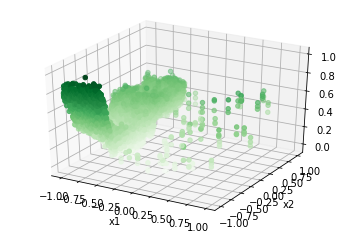

DEBUG:matplotlib.axes._base:update_title_pos


In [21]:
# Reload the data sets beacause we previously cast them into Tensor
train_x_name = "train_x.csv"
train_y_name = "train_y.csv"

train_x = np.loadtxt(train_x_name, delimiter=',')
train_y = np.loadtxt(train_y_name, delimiter=',')    

# load the test dateset
test_x_name = "test_x.csv"
test_x = np.loadtxt(test_x_name, delimiter=',')

# PLOT DATA
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(train_x[:,0], train_x[:,1], train_y, c=train_y, cmap='Greens');    
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()
fig.savefig('visual.png')


A visualization of the training set:

![image](visual.png "Title")

In [22]:
# PLOT LOSS
loss_50_RBF = [0.7372838258743286,
 0.7336408495903015,
 0.7300812005996704,
 0.7264455556869507,
 0.7227832674980164,
 0.7192136645317078,
 0.7155143022537231,
 0.7118554711341858,
 0.7082007527351379,
 0.7045102715492249,
 0.7008339762687683,
 0.6971420645713806,
 0.6934177875518799,
 0.6898286938667297,
 0.6860259175300598,
 0.6822872757911682,
 0.6785528063774109,
 0.67481929063797,
 0.671066403388977,
 0.667362630367279,
 0.663547694683075,
 0.6597496867179871,
 0.6559280753135681,
 0.6521740555763245,
 0.6483582854270935,
 0.6444932222366333,
 0.6407132148742676,
 0.636863112449646,
 0.6329894661903381,
 0.6291766166687012,
 0.6252681016921997,
 0.6213940382003784,
 0.6174920201301575,
 0.6136091351509094,
 0.6096917986869812,
 0.6057572364807129,
 0.6018401384353638,
 0.5979123711585999,
 0.5939492583274841,
 0.5899916291236877,
 0.586005449295044,
 0.5820373296737671,
 0.5780435800552368,
 0.5740146040916443,
 0.5700116753578186,
 0.5660097599029541,
 0.5619293451309204,
 0.5579075813293457,
 0.5538445115089417,
 0.5497879385948181]

In [23]:
loss_200_RBF = [0.7407978773117065,
 0.737268328666687,
 0.7336359024047852,
 0.7300554513931274,
 0.7264373302459717,
 0.7227652668952942,
 0.7191736698150635,
 0.7155269980430603,
 0.7118185758590698,
 0.7082059383392334,
 0.704554557800293,
 0.7008066773414612,
 0.6971200704574585,
 0.6934344172477722,
 0.689768373966217,
 0.6860253810882568,
 0.6822997331619263,
 0.6785236597061157,
 0.674807608127594,
 0.6710321307182312,
 0.6673129796981812,
 0.6635303497314453,
 0.659728467464447,
 0.6559441089630127,
 0.65214604139328,
 0.6483465433120728,
 0.6445245742797852,
 0.6406869292259216,
 0.6368102431297302,
 0.6330245733261108,
 0.629112720489502,
 0.6252515912055969,
 0.6213547587394714,
 0.6174572110176086,
 0.6135584712028503,
 0.6096677184104919,
 0.6057484149932861,
 0.6017941832542419,
 0.5979022979736328,
 0.5939054489135742,
 0.5899369120597839,
 0.585981011390686,
 0.5819771885871887,
 0.5779861211776733,
 0.5740030407905579,
 0.5699904561042786,
 0.5659512281417847,
 0.5619300007820129,
 0.5578595399856567,
 0.5538448691368103,
 0.5497607588768005,
 0.5456945896148682,
 0.5415965914726257,
 0.53751540184021,
 0.5334169864654541,
 0.5292996764183044,
 0.5251991748809814,
 0.5210481286048889,
 0.5169076323509216,
 0.5127673149108887,
 0.5086112022399902,
 0.5044301748275757,
 0.5002514719963074,
 0.4960775673389435,
 0.49185794591903687,
 0.4876314401626587,
 0.48344212770462036,
 0.4792076647281647,
 0.474959135055542,
 0.47070571780204773,
 0.4664444923400879,
 0.4621712565422058,
 0.45789679884910583,
 0.45361441373825073,
 0.4493216574192047,
 0.44503113627433777,
 0.4407012462615967,
 0.436390221118927,
 0.43205735087394714,
 0.4277353882789612,
 0.4233672022819519,
 0.41901952028274536,
 0.4146497845649719,
 0.4102838635444641,
 0.40590420365333557,
 0.4014984667301178,
 0.3971039950847626,
 0.39271852374076843,
 0.3882681727409363,
 0.38386207818984985,
 0.3794240951538086,
 0.3750030994415283,
 0.37052005529403687,
 0.36608609557151794,
 0.36160242557525635,
 0.3571377396583557,
 0.3526517152786255,
 0.3481546640396118,
 0.34367918968200684,
 0.3391571044921875,
 0.33465510606765747,
 0.33014780282974243,
 0.3256126642227173,
 0.321075975894928,
 0.3165452480316162,
 0.3119962513446808,
 0.307426393032074,
 0.30286136269569397,
 0.29832321405410767,
 0.29372045397758484,
 0.2891295254230499,
 0.2845715582370758,
 0.2799679636955261,
 0.2753795385360718,
 0.270751416683197,
 0.2661421597003937,
 0.26152503490448,
 0.2569270133972168,
 0.25227418541908264,
 0.24762636423110962,
 0.2429981827735901,
 0.2383105754852295,
 0.23367029428482056,
 0.22902309894561768,
 0.22433128952980042,
 0.21966344118118286,
 0.21499383449554443,
 0.21031968295574188,
 0.20560020208358765,
 0.20093858242034912,
 0.19625164568424225,
 0.19149190187454224,
 0.18677592277526855,
 0.18215329945087433,
 0.17739152908325195,
 0.17263105511665344,
 0.16788949072360992,
 0.16314741969108582,
 0.15840160846710205,
 0.15373171865940094,
 0.1488761305809021,
 0.1441163420677185,
 0.1393495798110962,
 0.13458973169326782,
 0.1297823190689087,
 0.1250573992729187,
 0.12025079131126404,
 0.11544536799192429,
 0.11067957431077957,
 0.10583197325468063,
 0.10106001049280167,
 0.0962940976023674,
 0.09145782142877579,
 0.0866178646683693,
 0.08181878179311752,
 0.07695385813713074,
 0.07217980176210403,
 0.06732229143381119,
 0.06250577419996262,
 0.05770006775856018,
 0.052883829921483994,
 0.04803645983338356,
 0.04319276660680771,
 0.03832540661096573,
 0.033520832657814026,
 0.028598900884389877,
 0.023771965876221657,
 0.018945256248116493,
 0.014093070290982723,
 0.00920997466892004,
 0.004313971847295761,
 -0.0004942255327478051,
 -0.005360054317861795,
 -0.010288779623806477,
 -0.015134171582758427,
 -0.020009057596325874,
 -0.02488507702946663,
 -0.029743093997240067,
 -0.034722261130809784,
 -0.039593297988176346,
 -0.0445685014128685,
 -0.04934103414416313,
 -0.054283853620290756,
 -0.05929313972592354,
 -0.06419350206851959,
 -0.06923460215330124,
 -0.07391644269227982,
 -0.07894112169742584,
 -0.08397260308265686,
 -0.08891429007053375,
 -0.09405774623155594,
 -0.09911379218101501,
 -0.10410473495721817,
 -0.10905174165964127,
 -0.11405853927135468,
 -0.11902479827404022,
 -0.12382020056247711,
 -0.12918896973133087,
 -0.13391520082950592,
 -0.13888303935527802]

In [24]:
loss_50_RQ = [0.7408291697502136,
 0.7373445630073547,
 0.7337273359298706,
 0.7301963567733765,
 0.7265686988830566,
 0.7229055762290955,
 0.7192351818084717,
 0.7154425382614136,
 0.7118580937385559,
 0.7081517577171326,
 0.7045953273773193,
 0.7007681131362915,
 0.6972112655639648,
 0.6935121417045593,
 0.6897627115249634,
 0.6860882043838501,
 0.6824801564216614,
 0.6784180998802185,
 0.6748413443565369,
 0.6711008548736572,
 0.6672126650810242,
 0.6634678244590759,
 0.6596406102180481,
 0.6558593511581421,
 0.6521669030189514,
 0.648127019405365,
 0.6447355151176453,
 0.6406757235527039,
 0.6367630362510681,
 0.6329981684684753,
 0.6290362477302551,
 0.6252118349075317,
 0.6213237643241882,
 0.6174219250679016,
 0.613435685634613,
 0.6096569299697876,
 0.6055914759635925,
 0.6017864346504211,
 0.5978978872299194,
 0.5937071442604065,
 0.5899136066436768,
 0.5858387351036072,
 0.5820266604423523,
 0.577890157699585,
 0.5739046931266785,
 0.5699408054351807,
 0.565947949886322,
 0.5617966651916504,
 0.5578041672706604,
 0.5536976456642151]

In [25]:
loss_200_RQ = [0.7410196661949158,
 0.737395703792572,
 0.7338513135910034,
 0.730100691318512,
 0.7264084219932556,
 0.7228573560714722,
 0.7190613746643066,
 0.7155680060386658,
 0.7118827104568481,
 0.7082642316818237,
 0.7045201659202576,
 0.7007850408554077,
 0.6972015500068665,
 0.6934447288513184,
 0.6896883249282837,
 0.6861289143562317,
 0.6824561357498169,
 0.6785658001899719,
 0.6748430132865906,
 0.6710515022277832,
 0.6673564314842224,
 0.6635303497314453,
 0.6596902012825012,
 0.6558852195739746,
 0.6520410776138306,
 0.6482564806938171,
 0.6444346904754639,
 0.6405996680259705,
 0.6367067694664001,
 0.6329953670501709,
 0.6290954351425171,
 0.6251645684242249,
 0.6213158965110779,
 0.6174340844154358,
 0.6135520935058594,
 0.6096988916397095,
 0.6056192517280579,
 0.601702094078064,
 0.5976876020431519,
 0.5938392281532288,
 0.5899083614349365,
 0.585891842842102,
 0.5818201899528503,
 0.5778283476829529,
 0.5739632248878479,
 0.5699422359466553,
 0.5658557415008545,
 0.5618480443954468,
 0.5576963424682617,
 0.5537614822387695,
 0.5496633648872375,
 0.5455306172370911,
 0.5414003133773804,
 0.5373219847679138,
 0.5332559943199158,
 0.529159426689148,
 0.5250018239021301,
 0.5210347771644592,
 0.5167162418365479,
 0.5125724077224731,
 0.5084154009819031,
 0.5043051242828369,
 0.5000858902931213,
 0.49587512016296387,
 0.4917609691619873,
 0.4874749779701233,
 0.4832253158092499,
 0.47891825437545776,
 0.4747765362262726,
 0.47044315934181213,
 0.46629253029823303,
 0.4619961380958557,
 0.45755067467689514,
 0.4532465934753418,
 0.44909313321113586,
 0.44478532671928406,
 0.44046908617019653,
 0.43615829944610596,
 0.4317442774772644,
 0.42738014459609985,
 0.42306986451148987,
 0.41873833537101746,
 0.4145037829875946,
 0.40993669629096985,
 0.4055618345737457,
 0.40106794238090515,
 0.3968156576156616,
 0.39237144589424133,
 0.3878096640110016,
 0.3834761083126068,
 0.37899139523506165,
 0.3746238648891449,
 0.3699914515018463,
 0.3655812442302704,
 0.3610653281211853,
 0.35674479603767395,
 0.35219934582710266,
 0.3476150333881378,
 0.34319111704826355,
 0.3386653661727905,
 0.3341696560382843,
 0.3296106159687042,
 0.32492250204086304,
 0.320463091135025,
 0.31589871644973755,
 0.31140241026878357,
 0.3069106638431549,
 0.3021818995475769,
 0.2978302240371704,
 0.29305145144462585,
 0.28855276107788086,
 0.2838907241821289,
 0.279284805059433,
 0.27454614639282227,
 0.27010437846183777,
 0.26534345746040344,
 0.26087087392807007,
 0.25611111521720886,
 0.2513771057128906,
 0.24664565920829773,
 0.2419988065958023,
 0.23729750514030457,
 0.23277586698532104,
 0.22813546657562256,
 0.22327066957950592,
 0.21858571469783783,
 0.21384307742118835,
 0.2091580033302307,
 0.20454749464988708,
 0.19988705217838287,
 0.1952030062675476,
 0.19031430780887604,
 0.1856636106967926,
 0.18083277344703674,
 0.17602944374084473,
 0.17126891016960144,
 0.1665983945131302,
 0.1617734432220459,
 0.15704314410686493,
 0.15238535404205322,
 0.14765579998493195,
 0.14270250499248505,
 0.13798731565475464,
 0.13292498886585236,
 0.12823647260665894,
 0.12362143397331238,
 0.11873777210712433,
 0.11375843733549118,
 0.10896897315979004,
 0.10412222892045975,
 0.09941406548023224,
 0.0947309210896492,
 0.08967708051204681,
 0.0849035307765007,
 0.07996275275945663,
 0.07521139085292816,
 0.0703568309545517,
 0.06544049829244614,
 0.060721978545188904,
 0.055874887853860855,
 0.05085190385580063,
 0.04614328593015671,
 0.04101845622062683,
 0.03615574166178703,
 0.031399454921483994,
 0.026684783399105072,
 0.021683650091290474,
 0.01681867055594921,
 0.011774173006415367,
 0.0068734148517251015,
 0.002297158120200038,
 -0.0030477242544293404,
 -0.007704370655119419,
 -0.012447916902601719,
 -0.017642833292484283,
 -0.022409534081816673,
 -0.027348166331648827,
 -0.0320054329931736,
 -0.03722361847758293,
 -0.04239923134446144,
 -0.047066010534763336,
 -0.05229789391160011,
 -0.05706952139735222,
 -0.06205932796001434,
 -0.06680095195770264,
 -0.0717138797044754,
 -0.07664956897497177,
 -0.08159057796001434,
 -0.08668705075979233,
 -0.09163597971200943,
 -0.09644429385662079,
 -0.10136514902114868,
 -0.10637997835874557,
 -0.11145210266113281,
 -0.11633820086717606,
 -0.12122305482625961,
 -0.12639957666397095,
 -0.13123664259910583,
 -0.13601437211036682,
 -0.14116224646568298]